# Jupyter notebook example: treatment of Fe K-edge XANES spectra of a volcanic melt

Charles Le Losq, IPGP

In this notebook, we will see how one can process spectra at the Fe K-edge using Larch in Jupyter.

This is particularly useful as Jupyter provides an "interactive" environment to play with Python, Larch and the spectra.

First we import the necessary libraries and Larch functions:

In [3]:
# this is a jupyter command that tells Jupyter how to handle your plot. 
#If you want interactive plots, replace 'inline' by 'notebook'
%matplotlib inline 

# now we import 'traditional' data processing Python libraries
import matplotlib.pyplot as plt
import numpy as np

# and now larch
import larch
from larch import Interpreter, Group
from larch.xafs import autobk, xftf, mback,pre_edge, pre_edge_baseline
from larch.io import read_ascii


We can now import data, here a Fe K-edge spectrum of a Fe foil:


In [4]:
data = read_ascii('../xafsdata/fe.060')

We can access the energy:

In [5]:
data.energy[:5] #just the first 5 elements

array([6911.98862, 6916.99353, 6922.006  , 6927.0007 , 6932.00293])

and calculate the absorbance spectrum from It and I0:

In [6]:
data.mu = -np.log(data.it/data.i0)

We can now plot the data with Matplotlib:

Text(0, 0.5, '$\\mu(E)$')

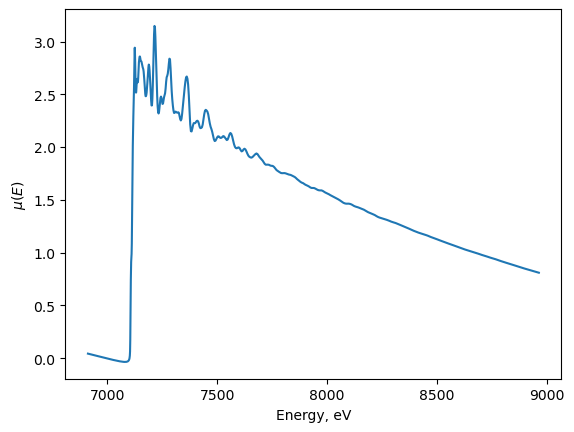

In [7]:
plt.plot(data.energy, data.mu, label='mu')
plt.xlabel("Energy, eV")
plt.ylabel("$\mu(E)$")

We can try the mback algorithm to correct the spectrum.

In [8]:
mback(data.energy, data.mu, group=data, z=26, edge='K', order=3, leexiang=False, fit_erfc=False, 
         pre1 = -100,
         pre2 = -20,
         norm1 = 50,
         norm2= 2000)

and we plot the result

Text(0, 0.5, 'Normalised $\\mu(E)$')

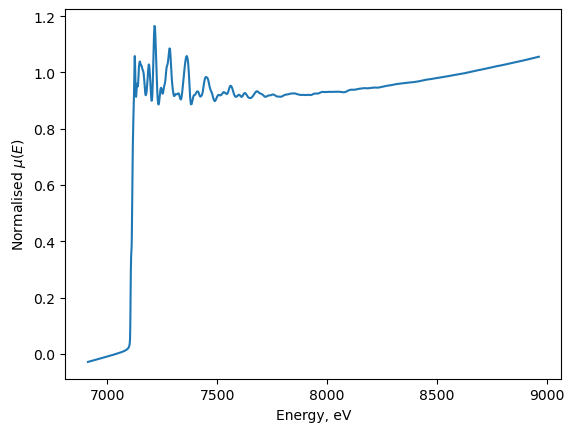

In [9]:
plt.figure()
plt.plot(data.energy, data.norm, label='Iron foil')
plt.xlabel("Energy, eV")
plt.ylabel("Normalised $\mu(E)$")

We can also normalize things with the preedge() function:

In [11]:
pre_edge(data.energy,data.mu,group=data, # energy, intensity, and the group to treat
         pre1 = -100, # the lower bond of the function to fit the pre-edge
         pre2 = -20, # the upper bond of the function to fit the pre-edge
         norm1 = 50, # the lower bond of the function to fit the post-edge
         norm2= 2000, # the upper bond of the function to fit the post-edge
         nnorm= 2, # degree for the polynomials
         nvict= 4 # energy exponent to use for pre-edge fit.
         )

And we can make a nice figure:

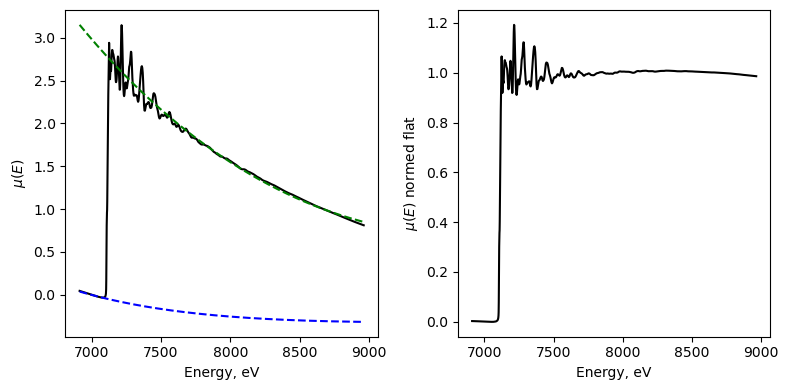

In [12]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(data.energy,data.mu,"k-")
plt.plot(data.energy,data.pre_edge,"b--")
plt.plot(data.energy,data.post_edge,"g--")
plt.xlabel("Energy, eV")
plt.ylabel("$\mu(E)$")

plt.subplot(1,2,2)
plt.plot(data.energy,data.flat,"k-")
plt.xlabel("Energy, eV")
plt.ylabel("$\mu(E)$ normed flat")

plt.tight_layout()

## Application to the Fe K-edge XANES spectrum of a molten lava (Phonolite)

The goal is to treat the Fe K-edge XANES spectrum and fit its pre-edge to link its centroid/position/parameters to the environment and valence of Fe in the glass/mineral/melt. 

We will perform that on data from C. Le Losq, R. Moretti, C. Oppenheimer, F. Baudelet, D.R. Neuville, Contrib Mineral Petrol 175 (2020) 64.

The spectrum was acquired during in situ experiments on the ODE beamline of the SOLEIL synchrotron, in dispersive mode. It is a Fe K-edge XANES spectrum acquired on a phonolite lava at 1630 °C in air.

Text(0.5, 1.0, 'Fe K-edge XANES spectrum of phonolite melt, 1630 °C')

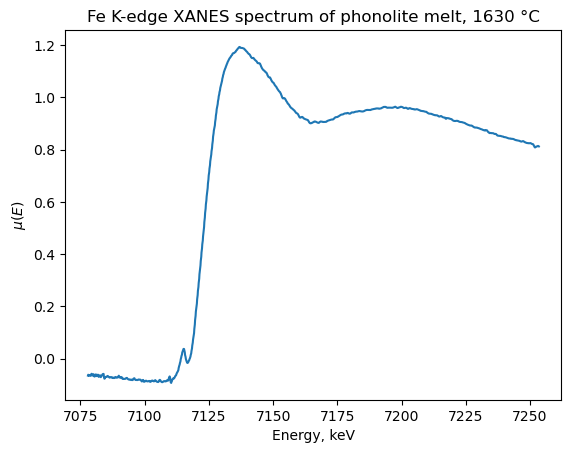

In [13]:
# We import the data
data = read_ascii('../xafsdata/EMG003.txt', labels=('energy', 'mu'))

# First vizualisation
plt.figure()
plt.plot(data.energy, data.mu, label='mu')
plt.xlabel("Energy, keV")
plt.ylabel("$\mu(E)$")
plt.title("Fe K-edge XANES spectrum of phonolite melt, 1630 °C")

Now we normalize the spectra and look at the result

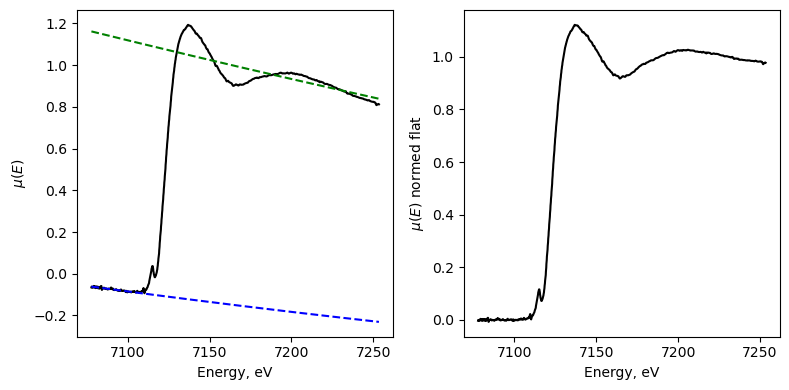

In [14]:
pre_edge(data.energy,data.mu,group=data, # energy, intensity, and the group to treat
         pre1 = -100, # the lower bond of the function to fit the pre-edge
         pre2 = -20, # the upper bond of the function to fit the pre-edge
         norm1 = 50, # the lower bond of the function to fit the post-edge
         norm2= 600, # the upper bond of the function to fit the post-edge
         nnorm= 1, # degree for the polynomials
         nvict= 4 # energy exponent to use for pre-edge fit.
         )

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(data.energy,data.mu,"k-")
plt.plot(data.energy,data.pre_edge,"b--")
plt.plot(data.energy,data.post_edge,"g--")
plt.xlabel("Energy, eV")
plt.ylabel("$\mu(E)$")

plt.subplot(1,2,2)
plt.plot(data.energy,data.flat,"k-")
plt.xlabel("Energy, eV")
plt.ylabel("$\mu(E)$ normed flat")

plt.tight_layout()

Now we can fit the pre-edge with different components. The XASViewer GUI provides [a way to do that easily](https://xraypy.github.io/xraylarch/wxxas_viewer.html#xasviewer-preedge), via a wrapper of the [lmfit](https://lmfit.github.io/lmfit-py/) library. There is a full page documenting the use of Larch built-in functions [here](https://millenia.cars.aps.anl.gov/xraylarch/downloads/xraylarch-2021-07_docs-examples/doc/fitting.html).

In this notebook, we will directly use `lmfit` for having the highest level of control. First, we extract the pre-edge peak between 7108 and 7120 eV, which we extract from the treated signal:

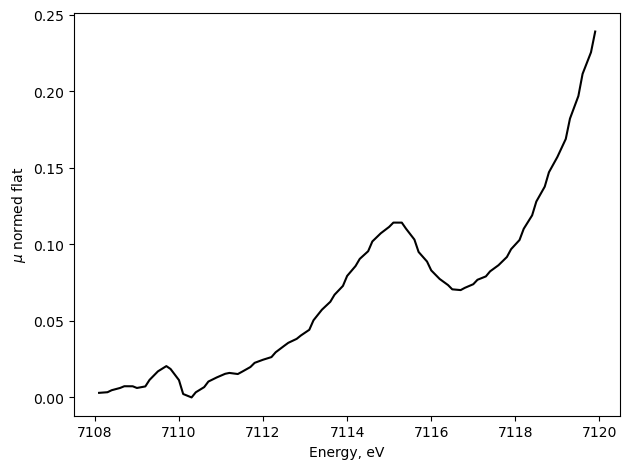

In [15]:
y_fit = data.flat[(data.energy> 7108)&(data.energy<7120)]-np.min(data.flat[(data.energy> 7108)&(data.energy<7120)])
x_fit = data.energy[(data.energy> 7108)&(data.energy<7120)]

plt.figure()
plt.plot(x_fit,y_fit, 'k-')
plt.xlabel("Energy, eV")
plt.ylabel("$\mu$ normed flat")
plt.tight_layout()

We will use a combination of two pseudo-voigt peaks for the contribition of Fe$^{2+}$ and Fe$^{3+}$, and an exponential background. We thus define functions for those below:

In [16]:
def pv(x,A,F,L,m):
    """pseudovoigt peak"""
    Lor = A/(1+((x-F)/L)**2)
    Gauss = A*np.exp(-np.log(2)*((x-F)/L)**2)
        
    return m*Gauss + (1-m)*Lor

def bkg(x, a, b, xo):
    """exponential background"""
    return a*np.exp(b*(x-xo))

Now we can use `lmfit` to perform the fit. We define the parameters in a dictionary, as explained in the help of `lmfit`. 

Given that this spectrum was acquired in situ, it is a bit more noisy than a glass spectrum acquired at room temperature. Considering this, several tweaks can be introduced to make the fit more robust: (i) the pseudovoigt peaks will share the width and the gaussian/lorentzian ratio, (ii) we assume that the position of the second peak is 1.5 eV higher than that of the first.

Note that we scale the X axis such that it is close to unity during the fit, by removing 7108 eV. This is invisible to the user, but this scaling helps fitting the exponential background.

[[Variables]]
    A_1:  8.5787e-12 (init = 0.1)
    A_2:  0.09796189 (init = 0.1)
    F_1:  5.40470913 (init = 4.9)
    L_:   1.53310944 (init = 2)
    m_:   1.3148e-05 (init = 0.5)
    a_:   31.4805829 (init = 0.52)
    b_:   0.60566147 (init = 0.55)
    xo_:  19.9376661 (init = 10.5)


Text(0, 0.5, '$\\mu(E)$ normed flat')

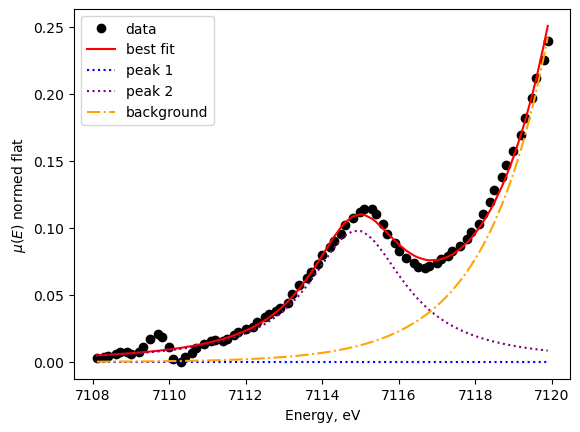

In [17]:
from lmfit import Minimizer, Parameters, report_fit

pfit = Parameters()
pfit.add(name='A_1', value=0.1, min=0) # amplitude of peak 1
pfit.add(name='A_2', value=0.1, min=0) # amplitude of peak 2
pfit.add(name='F_1', value=4.9, min=0) # position of peak 1, scaled
pfit.add(name='L_', value = 2.0, min=0) # half-width at half maximum of the peaks
pfit.add(name='m_', value = 0.5, min=0, max=1) # gaussian/loretnzian ratio

# parameters for the background.
pfit.add(name='a_', value=0.52, min=0)
pfit.add(name='b_', value=0.55, min=0)
pfit.add(name='xo_', value=10.5, min=0., max=20.) #position of the background, scaled

def residual(pars, x, data = None):
    peak1 = pv(x, pars['A_1'], pars['F_1'], pars['L_'], pars['m_'])
    peak2 = pv(x, pars['A_2'], pars['F_1']+1.5, pars['L_'], pars['m_'])
    background = bkg(x, pars['a_'], pars['b_'], pars['xo_'])
            
    model = peak1 + peak2 + background
    
    if data is None: # if we don't have data, the function only returns the direct calculation
        return model, peak1, peak2, background
    else:
        return model - data

mini = Minimizer(residual, pfit, fcn_args=(x_fit-7108, y_fit))
out = mini.leastsq()
report_fit(out.params)

# calculating the model given best parameters
m_, p1_, p2_, b_ = residual(out.params, x_fit-7108)

# plotting
plt.figure()
plt.plot(x_fit, y_fit, 'ko', label="data")
plt.plot(x_fit, m_, 'r-', label='best fit')
plt.plot(x_fit, p1_, 'b:', label='peak 1')
plt.plot(x_fit, p2_, ':', color="purple", label='peak 2')
plt.plot(x_fit, b_, '-.', color="orange", label='background')
plt.legend()
plt.xlabel("Energy, eV")
plt.ylabel("$\mu(E)$ normed flat")

Here is the end of this example. Things can be complexified at will. Have a good time with Larch!